In [37]:
# !pip install tensorflow-macos tensorflow-metal
import tensorflow as tf

In [38]:
import numpy as np

import matplotlib as mpl

import IPython.display as display
import PIL.Image

## Choose an image to dream-ify

In [39]:
url = 'https://upload.wikimedia.org/wikipedia/commons/5/5c/640x480-afframont_ujamondrone_leitosa.JPG'
# url = 'https://media.istockphoto.com/vectors/vector-geometric-seamless-pattern-with-simple-shapes-abstract-vector-id1289592868?k=20&m=1289592868&s=612x612&w=0&h=2MWCbI8Kqt5b9EWMRup9i_RUIlgYz0e8ySHG0RXF4MA='


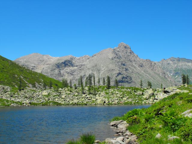

In [40]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=192)
show(original_img)
display.display(display.HTML('Image by someone'))

## Prepare the feature extraction model

In [41]:
import onnx

In [42]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
# base_model = tf.keras.models.load_model('models/model.hdf5')

In [43]:
# Maximize the activations of these layers
names = ['mixed2']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In [44]:
dream_model.compile()
# print(original_img.shape)
# show(deprocess(dream_model.predict(tf.expand_dims(original_img, axis=0))[0]))

## Calculate loss

The loss is the sum of the activations in the chosen layers. The loss is normalized at each layer so the contribution from larger layers does not outweigh smaller layers. Normally, loss is a quantity you wish to minimize via gradient descent. In DeepDream, you will maximize this loss via gradient ascent.

In [45]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

In [92]:
class Dream(tf.keras.layers.Layer):
  def __init__(self, model, **kwargs):
    super(Dream, self).__init__(**kwargs)
    self.model = model

  def call(self, img):
    olimg = img
    loss = tf.constant(0.0)
    for n in tf.range(50):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img[0], self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*0.02
        img = tf.clip_by_value(img, -1, 1)

    return img

In [93]:
input = tf.keras.layers.Input(shape=(None,None,3))
x = input
x = Dream(dream_model)(x)
preds = x

mmodel = tf.keras.Model(input,preds)

1/1 [==============================] - 1s 1s/step


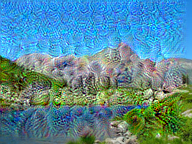

In [94]:
img = tf.keras.applications.inception_v3.preprocess_input(original_img)
img = tf.convert_to_tensor(img)
out = mmodel.predict(tf.expand_dims(img, axis=0))
show(deprocess(out[0]))

In [46]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [47]:
deepdream = DeepDream(dream_model)
deepdream.model.save('models/dreamr')
# import keras2onnx
# onnxm = keras2onnx.convert_keras(deepdream.model,'dreamr')
# onnx.save_model(onnxm, 'models/dreamr.onnx')
spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
# !pip install tf2onnx onnx onnxruntime
# !python -m tf2onnx.convert --saved-model models/dreamr --output "models/dreamr.onnx"

INFO:tensorflow:Assets written to: models/dreamr/assets


INFO:tensorflow:Assets written to: models/dreamr/assets


In [48]:
import onnx
onnx_model = onnx.load("models/dreamr.onnx")
onnx.checker.check_model(onnx_model)

In [60]:
# onnx_model.graph.input
deepdream.model.compile()
# print(original_img.shape)
out = deepdream.model.predict(tf.expand_dims(original_img, axis=0))
out.shape
# show(deprocess(out[0]))

1/1 [==============================] - 0s 346ms/step


(1, 15, 21, 288)

## Main Loop

In [50]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

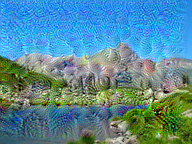

In [51]:
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)

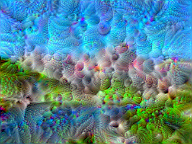

3.8784940242767334

In [52]:
import time
start = time.time()

OCTAVE_SCALE = 1.30

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 3):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=50, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end = time.time()
end-start